In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sync_plots import calc_and_plot_Q_and_S
from sync_calcs import dm2bloch, get_disipators, signal_hamiltonian
from qutip import *

# Unitary Data

In [2]:
states = np.load('unitary-v2-corrected.npy')

# Populations
ups = [state[0, 0].real for state in states]
downs = [state[1, 1].real for state in states]

In [43]:
detuning = 5 * 3 * 0.1
signal_strength = 5 * 2 * 0.1

H = signal_hamiltonian(detuning, signal_strength)

t = np.linspace(0, 16, 100)
result = mesolve(H, ket2dm(basis(2, 0)), t*0.2)

cont_ups = [state[0, 0].real for state in result.states]
cont_downs = [state[1, 1].real for state in result.states]

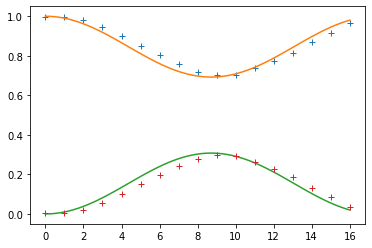

In [44]:
fig, ax = plt.subplots()

ax.plot(ups, '+')
ax.plot(t, cont_ups, '-')
ax.plot(t, cont_downs, '-')
ax.plot(downs, '+')

In [50]:
# Coherences
coh_arg = [np.angle(state[1, 0]) / np.pi for state in states]
coh_mod = [np.abs(state[1, 0]) for state in states]

cont_coh_arg = [np.angle(state[1, 0]) / np.pi for state in result.states]
cont_coh_mod = [np.abs(state[1, 0]) for state in result.states]

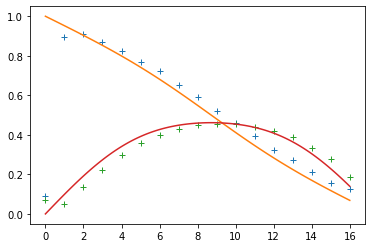

In [55]:
fig, ax = plt.subplots()

ax.plot(coh_arg, "+")
ax.plot(t, -np.array(cont_coh_arg) + 1, "-")
ax.plot(coh_mod, "+")
ax.plot(t, cont_coh_mod, "-")


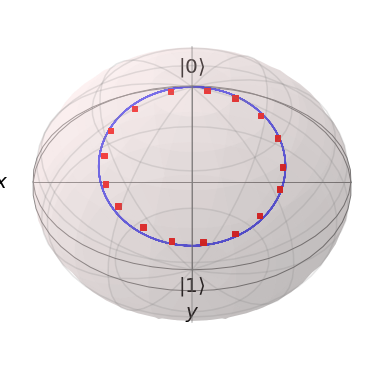

In [23]:
detuning = 0.3
signal_strength = 0.2

H = signal_hamiltonian(detuning, signal_strength)
result = mesolve(H, basis(2, 0), np.linspace(0, 100, 1000))

b = Bloch()
points = dm2bloch([Qobj(s) for s in states])
b.add_points(dm2bloch(result.states), 'l')
b.add_points(points, meth="s")
b.view = [0, 40]
b.show()

# Loss

In [53]:
states = np.load('unitary-loss-data-corrected.npy')

# Populations
ups = [state[0, 0].real for state in states]
downs = [state[1, 1].real for state in states]

# Coherences
coh_arg = [np.angle(state[1, 0]) / np.pi for state in states]
coh_mod = [np.abs(state[1, 0]) for state in states]

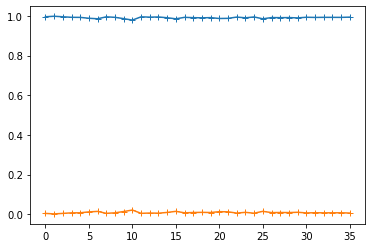

In [54]:
fig, ax = plt.subplots()

ax.plot(ups, '+-')
ax.plot(downs, '+-')

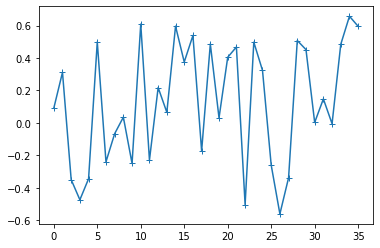

In [55]:
fig, ax = plt.subplots()

ax.plot(coh_arg, '+-')

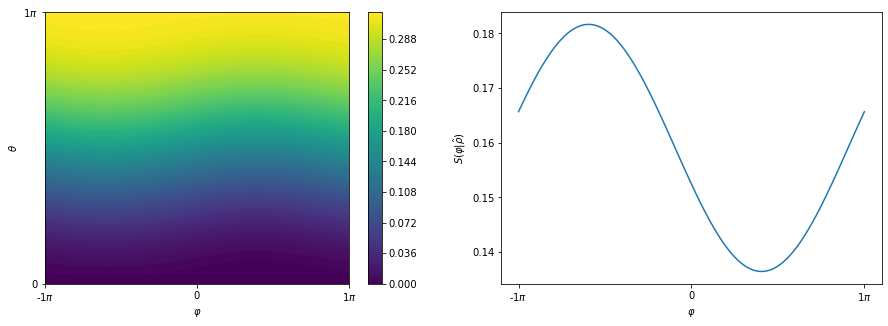

In [56]:
calc_and_plot_Q_and_S(Qobj(states[-1]))

# Loss 2

In [57]:
states = np.load('unitary-loss-data-2-corrected.npy')

# Populations
ups = [state[0, 0].real for state in states]
downs = [state[1, 1].real for state in states]

# Coherences
coh_arg = [np.angle(state[1, 0]) / np.pi for state in states]
coh_mod = [np.abs(state[1, 0]) for state in states]

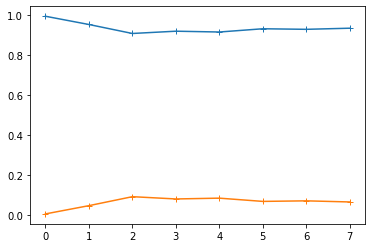

In [58]:
fig, ax = plt.subplots()

ax.plot(ups, '+-')
ax.plot(downs, '+-')

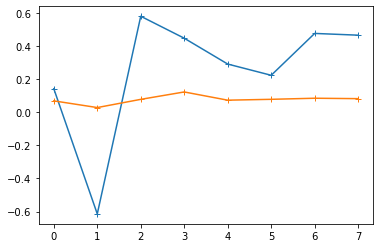

In [59]:
fig, ax = plt.subplots()

ax.plot(coh_arg, '+-')
ax.plot(coh_mod, '+-')

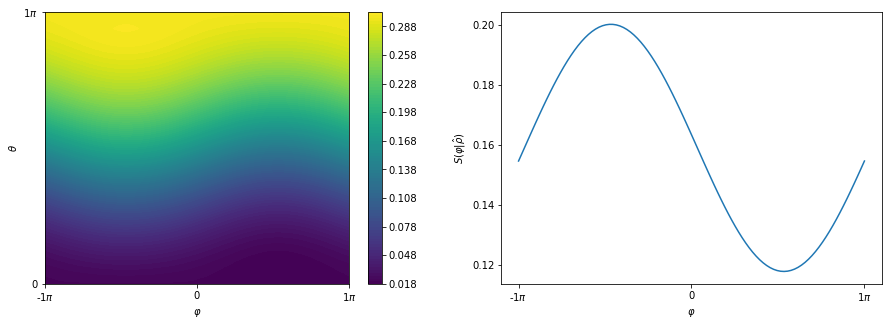

In [60]:
calc_and_plot_Q_and_S(Qobj(states[-1]))

# Loss + Gain

In [61]:
states = np.load('unitary-loss-gain-data-corrected.npy')

# Populations
ups = [state[0, 0].real for state in states]
downs = [state[1, 1].real for state in states]

# Coherences
coh_arg = [np.angle(state[1, 0]) / np.pi for state in states]
coh_mod = [np.abs(state[1, 0]) for state in states]

In [3]:
gain_amp = 0.1
loss_amp = 1
m = min(loss_amp, gain_amp)
detuning = 5 * 3 * m
signal_strength = 5 * 2 * m

J = 0.5
gain = gain_amp * lindblad_dissipator(jmat(J, "+"))
loss = loss_amp * lindblad_dissipator(jmat(J, "-"))
H = signal_hamiltonian(detuning, signal_strength)

result = mesolve(H, basis(2, 0), np.linspace(0, 100, 1000), c_ops=[loss, gain])


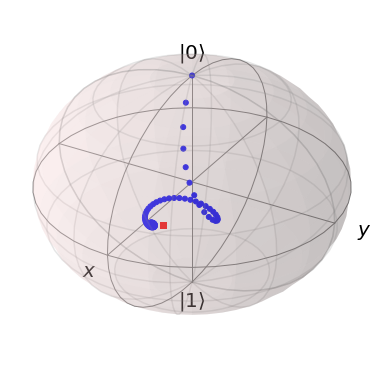

In [13]:
b = Bloch3d()
# points = dm2bloch([Qobj(s) for s in states])
b.add_points(dm2bloch(result.states), 's')

ssp = dm2bloch([
    [[0.68, -0.079-0.061j], [-0.079+0.061j, 0.32]]
])

b.add_points(-np.array(ssp))

# b.add_points(points, meth="l")
# b.view = [0, 90]
b.show()

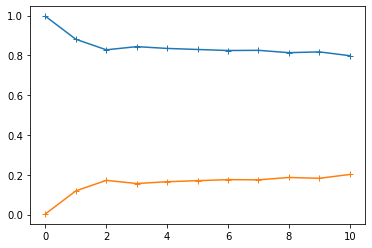

In [64]:
fig, ax = plt.subplots()

ax.plot(ups, '+-')
ax.plot(downs, '+-')

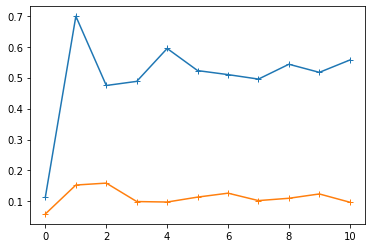

In [65]:
fig, ax = plt.subplots()

ax.plot(coh_arg, '+-')
ax.plot(coh_mod, '+-')

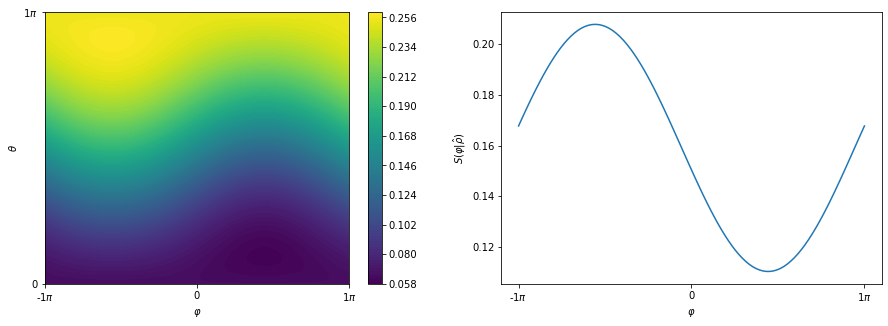

In [66]:
calc_and_plot_Q_and_S(Qobj(states[-1]))